# **Problem Statement**

## **Business Context**

Workplace safety in hazardous environments like construction sites and industrial plants is crucial to prevent accidents and injuries. One of the most important safety measures is ensuring workers wear safety helmets, which protect against head injuries from falling objects and machinery. Non-compliance with helmet regulations increases the risk of serious injuries or fatalities, making effective monitoring essential, especially in large-scale operations where manual oversight is prone to errors and inefficiency.

To overcome these challenges, SafeGuard Corp plans to develop an automated image analysis system capable of detecting whether workers are wearing safety helmets. This system will improve safety enforcement, ensuring compliance and reducing the risk of head injuries. By automating helmet monitoring, SafeGuard aims to enhance efficiency, scalability, and accuracy, ultimately fostering a safer work environment while minimizing human error in safety oversight.

## **Objective**

As a data scientist at SafeGuard Corp, you are tasked with developing an image classification model that classifies images into one of two categories:
- **With Helmet:** Workers wearing safety helmets.
- **Without Helmet:** Workers not wearing safety helmets.

## **Data Description**

The dataset consists of **631 images**, equally divided into two categories:

- **With Helmet:** 311 images showing workers wearing helmets.
- **Without Helmet:** 320 images showing workers not wearing helmets.

**Dataset Characteristics:**
- **Variations in Conditions:** Images include diverse environments such as construction sites, factories, and industrial settings, with variations in lighting, angles, and worker postures to simulate real-world conditions.
- **Worker Activities:** Workers are depicted in different actions such as standing, using tools, or moving, ensuring robust model learning for various scenarios.

# **Installing and Importing the Necessary Libraries**

In [ ]:
# When running on Google Colab Pro, we don’t need to manually handle the installation of CUDA or cuDNN
# these are usually pre-installed and configured properly on the platform. Colab manages GPU support for you.

!pip install tensorflow numpy -q

In [ ]:
import tensorflow as tf
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print(tf.__version__)

Num GPUs Available: 1
2.19.0


**Note:**

- After running the above cell, kindly restart the notebook kernel (for Jupyter Notebook) or runtime (for Google Colab) and run all cells sequentially from the next cell.

- On executing the above line of code, you might see a warning regarding package dependencies. This error message can be ignored as the above code ensures that all necessary libraries and their dependencies are maintained to successfully execute the code in this notebook.

In [46]:
import os
import random

# Importing numpy for Matrix Operations
import numpy as np
import pandas as pd
import seaborn as sns

# Importing pandas to read CSV files
import matplotlib.image as mpimg

# Importting matplotlib for Plotting and visualizing images
# NOTE: Matplotlib expects RGB format
import matplotlib.pyplot as plt

# Importing math module to perform mathematical operations
import math
# NOTE: cv2_imshow() expects BGR format
import cv2

# Tensorflow modules
import keras
import tensorflow as tf

# Import the ImageDataGenerator for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import the sequential module to define a sequential model
from tensorflow.keras.models import Sequential

# Define all the layers to build our CNN Model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization

# Import the optimizers which can be used in our model
from tensorflow.keras.optimizers import Adam,SGD

# Import the preprocessing module to preprocess the data
from sklearn import preprocessing

# Import train_test_split function to split the data into train and test
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import Model

# Import confusion_matrix to plot the confusion matrix
from keras.applications.vgg16 import VGG16

# Display images using OpenCV
from google.colab.patches import cv2_imshow

#Import functions for evaluating the performance of machine learning models
from sklearn.metrics import confusion_matrix, f1_score,accuracy_score, recall_score, precision_score, classification_report

# Import cv2_imshow from google.patches to display images
from sklearn.metrics import mean_squared_error as mse

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set random_state variable
RS = 42

In [47]:
# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
tf.keras.utils.set_random_seed(812)

# **Data Overview**


##Loading the data

**Loading the Dataset (.npload/.npy vs. cv2.imread)**
- The images for this project were provided in a pre-processed NumPy array (images_proj.npy), which I loaded using np.load(). This approach differs from using cv2.imread() in that the images have already been read from their original files, converted into arrays, standardized to the same size, and stacked into a single structured dataset.
- Use of the .npy file ensures consistent ordering, correct label alignment, and identical data across all students, which is essential for reproducibility and fair evaluation.
- In contrast, cv2.imread() is better used to load individual images but requires manual directory traversal, ordering, and label matching... tasks that are unnecessary in this context because the dataset has already been provided.

In [48]:
# Connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
images = np.load("/content/drive/MyDrive/AIML/Project6 HelmNet/images_proj.npy")

In [50]:
data = pd.read_csv("/content/drive/MyDrive/AIML/Project6 HelmNet/Labels_proj.csv")

# **Exploratory Data Analysis**

**Summary of EDA Findings**

I do not believe any of the models are actually going to be able to function in a real world production environment. Training only on the images provided, some of the the "no helmet" pictures do not even show whether there is a helmet or not. I think the models will all learn "close up of face" vs. "not close up of face" only.  As such I expect the models to perform very well, but I would never allow them into production.

**Note:** The images displayed during EDA are generated using random sampling, so the specific images shown may differ each time the notebook is run.

**Confirming the Color Format (BGR vs. RGB)**
- To better understand the dataset, I displayed the same image using both cv2_imshow() and matplotlib.pyplot.imshow().
- cv2_imshow() displayed the image with correct colors.
- plt.imshow() displayed the same image with inverted colors (blue ↔ red).
- The difference occurs because OpenCV stores images in BGR format, whereas Matplotlib expects RGB.
- Displaying with both methods was not redundant—it was a deliberate and useful step to confirm that the dataset was indeed stored in BGR format.
- I felt this was important for correct preprocessing and visualization even thought we plan to converting images to grayscale.

**Numerical Balance in the Dataset**
* The dataset contains 631 images, all at 200×200×3 resolution.
* There are 311 images labeled “With Helmet” and 320 labeled “Without Helmet,” indicating the dataset is numerically balanced with respect to class count.

**Contextual Bias in Image Composition**
* Although the dataset is numerically balanced, visual inspection reveals a notable contextual bias:
  * “Without Helmet” images are almost entirely close-up headshots with simple, uncluttered backgrounds.
  * “With Helmet” images typically include upper-body or full-body views with construction equipment, buildings, signage, or natural elements in the background.
* This discrepancy may cause the model to rely on background cues, camera distance, or framing rather than actually detecting whether a helmet is present.

**Reflection / Mirroring Artifact**
* Several “With Helmet” images contain a reflection padding artifact along the top and bottom ~16% of the image.
* In many cases, these mirrored regions duplicate parts of the helmet or nearby tools — effectively repeating key class-defining features.
* Because this artifact occurs only in the “With Helmet” class, it creates a class-specific shortcut that the model might learn instead of genuine helmet features, reducing generalization in real-world settings.

**Demographic Homogeneity in the “No Helmet” Class**
* A review of all “No Helmet” images shows that this class exhibits very limited demographic diversity and consists almost entirely of close-up headshots of a small number of individuals captured from multiple angles or with different facial expressions.
* This creates two concerns:
  * Identity-Level Redundancy: Many images appear to show the same individuals, reducing intra-class variability.
  * Demographic Narrowness: The lack of demographic variation increases the risk that the model may overfit to specific facial characteristics or skin tones rather than learning features related to helmet absence.
* For the purpose of this academic project, these limitations will be documented and addressed primarily through controlled data augmentation.
In a production setting, the “No Helmet” class would require a much more diverse and representative set of images to avoid demographic and identity-related bias.

**Planned Mitigation**
* Mirroring Artifact
  * Crop the top and bottom ~16% of each image to remove the mirrored regions,then resize back to 200×200.
  * This prevents the model from learning spurious border patterns and ensures more reliable feature extraction.
* Contextual Bias:
  * Apply controlled data augmentation to both classes, including:
  * Light random cropping (≤10%)
  * Zoom-in transformations
* Small horizontal/vertical shifts
  * These augmentations maintain the helmet within the frame while reducing reliance on background or framing differences, thereby improving generalization.
* Scope of Mitigation:
  * In a production setting, the ideal long-term solution would be to collect additional “Without Helmet” images matching the environmental diversity of the “With Helmet” class.
  * For this academic project, bias will be addressed solely through controlled augmentation and consistent preprocessing.

#### Info, Class Counts, Shape

In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 631 entries, 0 to 630
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Label   631 non-null    int64
dtypes: int64(1)
memory usage: 5.1 KB


In [52]:
feature_counts = data['Label'].value_counts()
print(feature_counts)

Label
0    320
1    311
Name: count, dtype: int64


In [53]:
print(images.shape)
print(type(images))

(631, 200, 200, 3)
<class 'numpy.ndarray'>


#### Identify format (RBG vs BGR) of images

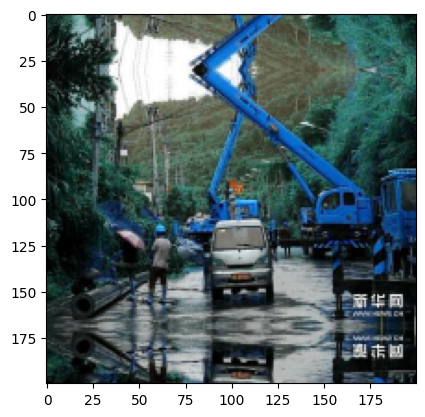

In [54]:
# Display images[0] with MatplotLib
plt.imshow(images[0])
plt.show()

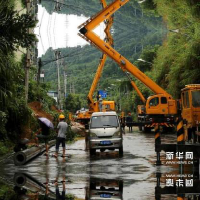

In [55]:
# Display images[0] with cv2_imshow()
cv2_imshow(images[0])

####Plotting random images from each of the classes and Idenitfying Class Imbalances

In [56]:
# This is a simple script to identify the range of index values that are 0 and 1
val = data['Label'][0]
print("At index 0 'Label' is", val)
for index, row in data.iterrows():
  if (row['Label'] != val):
    val = row['Label']
    print("At index", index, "'Label' is", val)

At index 0 'Label' is 1
At index 271 'Label' is 0
At index 551 'Label' is 1
At index 591 'Label' is 0


* I want to review 5 random images for each range of images
* data[0:271] == 1
* data[271:551] == 0
* data[551:591] == 1
* data[591:630] == 0

Indexes with helmet: [16, 144, 151, 180, 203, 555, 572, 574, 575, 583] 

Indexes with NO helmet: [371, 375, 380, 385, 484, 595, 611, 614, 625, 629] 

These are all images recorded as a helmet present
index 16


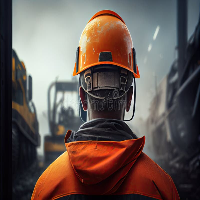

index 144


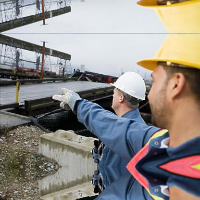

index 151


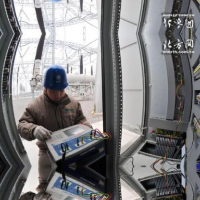

index 180


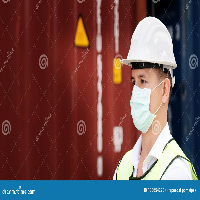

index 203


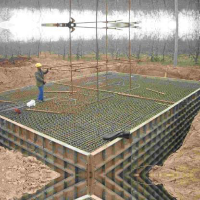

index 555


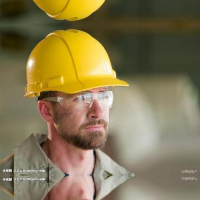

index 572


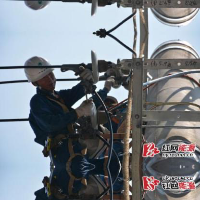

index 574


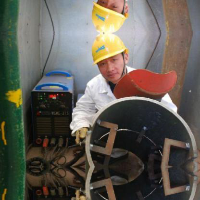

index 575


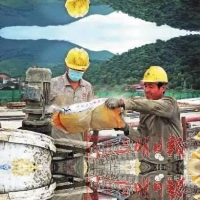

index 583


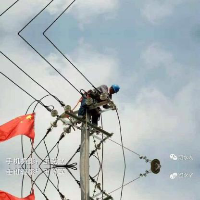


These are all images recorded as a NO helmet present
index 371


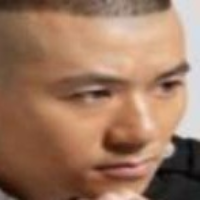

index 375


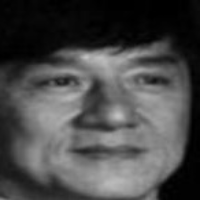

index 380


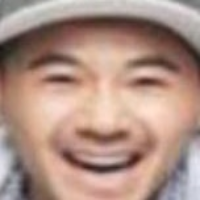

index 385


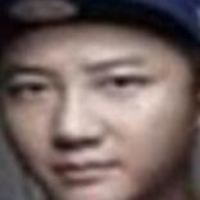

index 484


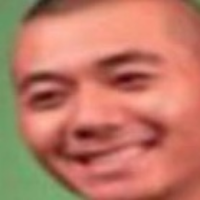

index 595


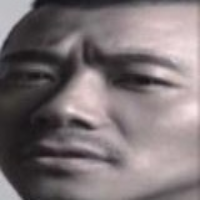

index 611


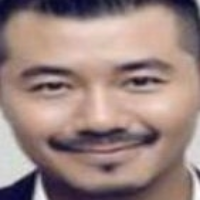

index 614


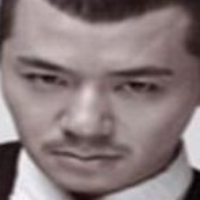

index 625


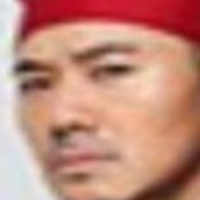

index 629


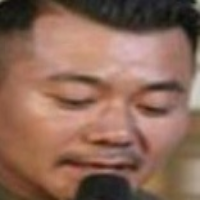

In [57]:
# Generate a list of random numbers for both helmet and no helmet images
random_helm = []
random_no = []
random_helm += random.sample(range(0, 271), 5)
random_no += random.sample(range(271, 551), 5)
random_helm += random.sample(range(551, 591), 5)
random_no += random.sample(range(591, images.shape[0]), 5)

# sort lists and print the values of each
random_helm.sort()
random_no.sort()
print("Indexes with helmet:", random_helm, "\n")
print("Indexes with NO helmet:",random_no, "\n")

# display all helmet images sampled
print("These are all images recorded as a helmet present")
for x in random_helm:
  print("index", x)
  cv2_imshow(images[x])

del x
print("\nThese are all images recorded as a NO helmet present")
for x in random_no:
  print("index", x)
  cv2_imshow(images[x])

**Note:** The code below has been commented out as it will display all 320 "no helmet" images.  I did not want this to take up space in the project submission however, it was an important part of the EDA.

In [58]:
# Filter indices of "No Helmet" images
#no_helmet_indices = [i for i in range(len(data['Label'])) if data['Label'][i] == 0]
# Number of columns in the grid
#cols = 4
#rows = len(no_helmet_indices) // cols + 1
#plt.figure(figsize=(12, rows * 3))
#for idx, img_idx in enumerate(no_helmet_indices):
#    plt.subplot(rows, cols, idx + 1)
#    plt.imshow(cv2.cvtColor(images[img_idx], cv2.COLOR_BGR2RGB))
#    plt.axis('off')
#    plt.title("No Helmet")
#plt.tight_layout()
#plt.show()

# **Data Preprocessing**

#### Cropping and Resizing for Data Correction

Although resizing after cropping introduces some mild distortion, the effect is minimal and visually consistent across interpolation methods. I tested INTER_AREA, INTER_LINEAR, INTER_CUBIC, and INTER_NEAREST, and found no meaningful difference in the quality of the resulting images at this scale. Because the cropping itself is the dominant transformation, the interpolation method does not materially affect the outcome. The key objective is to standardize image size after correcting the artifact, and the resizing operation accomplishes this reliably through any of the standard interpolation approaches.

**Note on aspect ratio**: While cropping removes equal proportions from the top and bottom of each “With Helmet” image, temporarily altering the aspect ratio. However, CNNs are generally robust to such minor geometric transformations but do require uniform, consistent input shape so they can learn patterns.

**Note on brightness, contrast, Gaussian blurring**: While these techniques were demonstrated in class they are not used in this project because they can distort key visual features, amplify existing biases between classes, and degrade the limited signal available in this small dataset. Our augmentation strategy instead focuses on controlled geometric transformations that preserve helmet features while reducing contextual bias.

**Note on Regions of Interest**: In more advanced production systems, Region of Interest (ROI) extraction would often be used to isolate the head or helmet region before classification. However, ROI extraction requires object detectors or bounding-box annotations, which are not available in this dataset and are beyond the scope of this project. Therefore, we applied only the fixed percentage cropping to remove known image artifacts, while preserving the full content needed for classification.



In [59]:
# Set cropping percentage to 16%
CROP_PCT = 0.16

# Make a copy so we don't destroy the original images
cropped_images = images.copy()

for i in range(len(cropped_images)):
    # 1 = "With Helmet"
    if data['Label'][i] == 1:
        img = cropped_images[i]
        # Since this is a vertical cropping, get the pixel count of the height
        h, w = img.shape[:2]

        # Compute crop boundaries (actual row numbers)
        top = int(h * CROP_PCT)
        bottom = int(h * (1.0 - CROP_PCT))

        # Crop top and bottom
        # [top:bottom] Select only the rows between top to bottom
        # [, :] and keep all columns
        # This slicing is inclusive of top index but exclusive of bottom index
        cropped = img[top:bottom, :]

        # Resize back to original size (200x200)
        resized = cv2.resize(cropped, (w, h), interpolation=cv2.INTER_LINEAR)

        cropped_images[i] = resized

# NOTE: From this point onward, we use `cropped_images` instead of `images`

In [60]:
# Select indices of images requiring cropping
crop_indices = [144,152,203,555,572,574,575,583]

for idx in crop_indices:
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    fig.suptitle(f"Index: {idx}", fontsize=14)

    # --- Original image ---
    axes[0].imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))
    axes[0].set_title("Original")
    axes[0].axis('off')

    # --- Cropped + Resized image ---
    axes[1].imshow(cv2.cvtColor(cropped_images[idx], cv2.COLOR_BGR2RGB))
    axes[1].set_title("Cropped + Resized")
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()


Output hidden; open in https://colab.research.google.com to view.

**NOTE: From this point onward, we use `cropped_images` instead of `images` for CNN**

####Preparing Color Images for VGG-16 (BGR → RGB, 224×224×3)

After converting the original BGR images to RGB and resizing them to the VGG-required 224×224×3 format, we normalized all pixel values to the [0,1] range. Since we use only the frozen convolutional base of VGG-16 and train a new classifier head, this simplified normalization is appropriate and aligns with common transfer-learning practice.

- Convert BGR to RGB (swap channels).
- Resize 200×200 to 224×224 (if your corrections left you at 200×200).
- Normalize to [0,1]
- Ensure shape (N, 224, 224, 3), float32, and range [0,1]

In [61]:
# color_images: your cropped & resized original color images (N, 200, 200, 3)
vgg_images = []

for img in cropped_images:
    # Convert BGR to RGB
    rgb = img[:, :, ::-1]

    # Resize 200×200 to 224×224
    resized = cv2.resize(rgb, (224, 224), interpolation=cv2.INTER_LINEAR)

    # Convert to float32 and normalize to [0,1]
    normalized = resized.astype('float32') / 255.0

    vgg_images.append(normalized)

# Convert list to NumPy array: shape (N, 224, 224, 3)
vgg_images = np.array(vgg_images, dtype='float32')

print("VGG-ready images shape:", vgg_images.shape)
print("dtype:", vgg_images.dtype)
print("min/max pixel values:", np.min(vgg_images), np.max(vgg_images))

VGG-ready images shape: (631, 224, 224, 3)
dtype: float32
min/max pixel values: 0.0 1.0


#### Splitting the color VGG-16 dataset

In [62]:
# Features and labels for VGG-16
X_vgg = vgg_images
y_vgg = np.array(data['Label'])

# First split: Train (70%) and Temp (30%)
X_train_vgg, X_temp_vgg, y_train_vgg, y_temp_vgg = train_test_split(
    X_vgg,
    y_vgg,
    test_size=0.30,
    stratify=y_vgg,
    random_state=RS
)

# Second split: Validation (15%) and Test (15%) from Temp
X_val_vgg, X_test_vgg, y_val_vgg, y_test_vgg = train_test_split(
    X_temp_vgg,
    y_temp_vgg,
    test_size=0.50,
    stratify=y_temp_vgg,
    random_state=RS
)

print("VGG Train:", X_train_vgg.shape)
print("VGG Val:  ", X_val_vgg.shape)
print("VGG Test: ", X_test_vgg.shape)

VGG Train: (441, 224, 224, 3)
VGG Val:   (95, 224, 224, 3)
VGG Test:  (95, 224, 224, 3)


#### Converting images to grayscale for basic CNN

- Although grayscale conversion can be implemented manually using nested loops and weighted RGB averages (as demonstrated in class), this approach is slow and unnecessary for a real preprocessing pipeline.
- Since our dataset contains hundreds of 200×200 images and is stored in BGR format through OpenCV, we use cv2.cvtColor(..., cv2.COLOR_BGR2GRAY) instead. This method applies the same luminance formula (weighting) but does so in a vectorized, optimized manner, producing a single-channel grayscale image more efficiently and consistently.
- **NOTE:** the resulting grayscale images will ONLY be used for the SIMPLE CNN and not for anything involving VGG-16

In [63]:
# Create a new array to hold grayscale images
gray_images = []

for img in cropped_images:   # <-- Use cropped_images, not original images
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray_images.append(gray)

gray_images = np.array(gray_images)

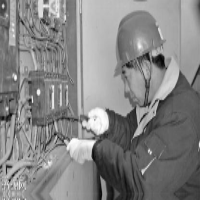

In [64]:
cv2_imshow(gray_images[6])

#### Splitting the grayscale dataset



- The dataset was split into training (70%), validation (15%), and test (15%) sets using stratified sampling to ensure that each subset preserved the original class distribution.
- Training set: 441 images
  - 224 No Helmet
  - 217 With Helmet
- Validation set: 95 images
  - 48 No Helmet
  - 47 With Helmet
- Test set: 95 images
  - 48 No Helmet
  - 47 With Helmet
- This confirms that stratification was successful and that each subset maintains nearly identical proportions of the two classes.
- Balanced splits are particularly important for small datasets to ensure fair model evaluation and prevent unintended bias during training.

In [65]:
# Features and labels
X = gray_images
y = np.array(data['Label'])

# First split: Train (70%) and Temp (30%)
X_train_gray, X_temp_gray, y_train_gray, y_temp_gray = train_test_split(
    X,
    y,
    test_size=0.30,
    stratify=y,
    random_state=RS
)

# Second split: Validation (15%) and Test (15%) from Temp
X_val_gray, X_test_gray, y_val_gray, y_test_gray = train_test_split(
    X_temp_gray,
    y_temp_vgg,
    test_size=0.50,
    stratify=y_temp_gray,
    random_state=RS
)

print("Train shape:", X_train_gray.shape, "Labels:", y_train_gray.shape)
print("Val shape:",   X_val_gray.shape,   "Labels:", y_val_gray.shape)
print("Test shape:",  X_test_gray.shape,  "Labels:", y_test_gray.shape)

# Check for class balance in each split
for name, labels in [("Train", y_train_gray), ("Val", y_val_gray), ("Test", y_test_gray)]:
    unique, counts = np.unique(labels, return_counts=True)
    print(f"{name} class distribution:", dict(zip(unique, counts)))


Train shape: (441, 200, 200) Labels: (441,)
Val shape: (95, 200, 200) Labels: (95,)
Test shape: (95, 200, 200) Labels: (95,)
Train class distribution: {np.int64(0): np.int64(224), np.int64(1): np.int64(217)}
Val class distribution: {np.int64(0): np.int64(48), np.int64(1): np.int64(47)}
Test class distribution: {np.int64(0): np.int64(48), np.int64(1): np.int64(47)}


#### Normalize the grayscale images (not VGG)

In [66]:
# Convert to float32 and normalize pixel values to [0, 1]

X_train_gray = X_train_gray.astype("float32") / 255.0
X_val_gray   = X_val_gray.astype("float32") / 255.0
X_test_gray  = X_test_gray.astype("float32") / 255.0

print(X_train_gray.min(), X_train_gray.max())
print(X_val_gray.min(),   X_val_gray.max())
print(X_test_gray.min(),  X_test_gray.max())

0.0 1.0
0.0 1.0
0.0 1.0


#### Add Channel Dimension

- After preprocessing, every image is 200×200 grayscale however, convolutional layers in Keras expect inputs with a channel dimension, such as (H, W, 1) for grayscale images or (H, W, 3) for RGB images.
- Here I added a final channel dimension using [..., np.newaxis], which converted the shape of X_train, X_val, and X_test from (N, 200, 200) to (N, 200, 200, 1).
- NOTE: this operation did not change the image content, it simply allows us to tell the model that each pixel has one intensity channel instead of three for color images.

In [67]:
# Confirm shapes before adding channel dimension
print("Before:")
print("X_train:", X_train_gray.shape)
print("X_val:  ", X_val_gray.shape)
print("X_test: ", X_test_gray.shape)

# Add channel dimension: (N, 200, 200) -> (N, 200, 200, 1)
X_train_gray = X_train_gray[..., np.newaxis]
X_val_gray   = X_val_gray[..., np.newaxis]
X_test_gray  = X_test_gray[..., np.newaxis]

# Verify shapes after
print("\nAfter:")
print("X_train_gray:", X_train_gray.shape)
print("X_val_gray:  ", X_val_gray.shape)
print("X_test_gray: ", X_test_gray.shape)

Before:
X_train: (441, 200, 200)
X_val:   (95, 200, 200)
X_test:  (95, 200, 200)

After:
X_train_gray: (441, 200, 200, 1)
X_val_gray:   (95, 200, 200, 1)
X_test_gray:  (95, 200, 200, 1)


# **Model Building**

### Model Evaluation Criterion

- Model performance will be evaluated using accuracy, precision, recall, and F1-score computed on the validation set, as these metrics directly reflect the system’s reliability in distinguishing between compliant (helmet) and non-compliant (no-helmet) workers.
- Overall accuracy provides a general measure of correctness, precision and recall allow us to assess how confidently and consistently the model identifies true safety violations.
- In this context, false positives—cases where the model predicts a helmet when none is present—are especially critical because they may allow unsafe conditions to go unnoticed.
- The F1-score offers a balanced measure that captures both types of errors. A confusion matrix will also be examined to visualize these error patterns and understand where the model may require improvement before deployment.
- Together, these evaluation criteria ensure that the selected model aligns with the objective of reliable, real-time helmet compliance monitoring in industrial environments.

### Utility Functions

In [68]:
# Updated utility function for evaluating Keras classification models
# Replaces the original statsmodels-based version that was provided

def model_performance_classification_keras(model, predictors, target):
    """
    Function to compute classification model performance metrics
    for a Keras binary classifier.

    model:     trained Keras model
    predictors: input data (NumPy array)
    target:     true labels (NumPy array or Pandas Series) with values 0/1
    """

    # still checking which probabilities are greater than threshold
    # and converting y_prob into a prediction (0/1 versus True/False)
    # y_prob > 0.5 → converts probabilities to True/False
    # .astype(int) → converts True/False to 1/0
    y_prob = model.predict(predictors).reshape(-1)
    pred = (y_prob > 0.5).astype(int)

    # ORIGINAL CODE expected `target` to be a Pandas Series.
    # We now ensure it is a 1-D NumPy array for Keras compatibility.
    target = np.array(target).reshape(-1)

    # Computing metrics (same as original function)
    acc = accuracy_score(target, pred)
    recall = recall_score(target, pred, average='weighted')
    precision = precision_score(target, pred, average='weighted')
    f1 = f1_score(target, pred, average='weighted')

    # Return a Dataframe (same as original version)
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1 Score": f1
        },
        index=[0],
    )
    return df_perf

In [69]:
def plot_confusion_matrix(model, predictors, target, ml=False):
    """
    Function to plot the confusion matrix

    model: classifier (Keras model in this project)
    predictors: input data (NumPy array)
    target: true labels (NumPy array or Pandas Series), values 0/1
    ml: unused here; kept for compatibility with original signature
    """
    # still checking which probabilities are greater than threshold
    # and converting y_prob into a prediction (0/1 versus True/False)
    # y_prob > 0.5 → converts probabilities to True/False
    # .astype(int) → converts True/False to 1/0
    y_prob = model.predict(predictors).reshape(-1)
    pred = (y_prob > 0.5).astype(int)

    # ORIGINAL CODE expected `target` to be a Pandas Series.
    # We now ensure it is a 1-D NumPy array for Keras compatibility.
    target = np.array(target).reshape(-1)

    # Compute confusion matrix with TensorFlow.
    cm = tf.math.confusion_matrix(target, pred)

    # Plot confusion matrix as heatmap.
    f, ax = plt.subplots(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        linewidths=.4,
        fmt="d",
        square=True,
        cbar=False,
        xticklabels=['No Helmet', 'Helmet'],
        yticklabels=['No Helmet', 'Helmet'],
        ax=ax
    )
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()


In [70]:
def plot_training_accuracy(history, model_name="Model"):
    """
    Plots training and validation accuracy for a given Keras model history.

    history:    Keras History object returned by model.fit()
    model_name: string to label the plot (e.g., 'CNN', 'VGG-16 Base')
    """
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{model_name} Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()


In [71]:
def visualize_predictions(model, images, labels, class_names=['No Helmet', 'Helmet'], num_samples=8):
    """
    Plots random sample predictions from a trained Keras binary classifier.

    Highlights incorrect predictions clearly.

    model:       trained Keras model
    images:      input data (NumPy array: grayscale or RGB)
    labels:      true labels (0/1)
    class_names: ['No Helmet', 'Helmet']
    num_samples: number of samples to display
    """
    indices = np.random.choice(len(images), num_samples, replace=False)

    plt.figure(figsize=(15, 3 * num_samples))

    for i, idx in enumerate(indices):
        img = images[idx]
        true_label = labels[idx]

        # Predict probability
        prob = model.predict(img.reshape(1, *img.shape)).reshape(-1)[0]
        pred_label = int(prob > 0.5)

        # Determine correctness
        correct = (pred_label == true_label)
        status = "CORRECT" if correct else "WRONG"
        color = "green" if correct else "red"

        # Display image
        plt.subplot(num_samples, 2, 2*i + 1)
        if img.ndim == 3 and img.shape[-1] == 1:  # grayscale
            plt.imshow(img.squeeze(), cmap='gray')
        else:
            plt.imshow(img)  # RGB
        plt.axis('off')

        # Display text panel
        plt.subplot(num_samples, 2, 2*i + 2)
        plt.text(
            0.1, 0.5,
            f"Predicted: {class_names[pred_label]}\n"
            f"Probability: {prob:.4f}\n"
            f"Actual: {class_names[true_label]}\n"
            f"Status: {status}",
            fontsize=12,
            color=color
        )
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [72]:
def show_misclassified_images(model, images, labels, class_names=['No Helmet', 'Helmet']):
    """
    Displays all misclassified images with prediction details.

    model:       trained Keras model
    images:      input data (NumPy array)
    labels:      true labels (0/1)
    class_names: ['No Helmet', 'Helmet']
    """

    # Predict probabilities and convert to class predictions
    probs = model.predict(images).reshape(-1)
    preds = (probs > 0.5).astype(int)

    # Identify misclassified indices
    mis_idx = np.where(preds != labels)[0]

    print(f"Total misclassified: {len(mis_idx)}")

    if len(mis_idx) == 0:
        print("No misclassifications found.")
        return

    # Setup figure
    plt.figure(figsize=(12, 4 * len(mis_idx)))

    for i, idx in enumerate(mis_idx):
        img = images[idx]
        true_label = labels[idx]
        pred_label = preds[idx]
        prob = probs[idx]

        # Image subplot
        plt.subplot(len(mis_idx), 2, 2*i + 1)
        if img.ndim == 3 and img.shape[-1] == 1:   # grayscale
            plt.imshow(img.squeeze(), cmap='gray')
        else:
            plt.imshow(img)                        # RGB
        plt.axis('off')

        # Text subplot
        plt.subplot(len(mis_idx), 2, 2*i + 2)
        plt.text(
            0.1, 0.5,
            f"Predicted: {class_names[pred_label]}\n"
            f"Probability: {prob:.4f}\n"
            f"Actual: {class_names[true_label]}",
            fontsize=12,
            color="red"
        )
        plt.axis('off')

    plt.tight_layout()
    plt.show()


### Model 1: Simple Convolutional Neural Network (CNN)

- The baseline CNN achieved high validation performance (accuracy ~97.8%, strong precision/recall/F1), but this result reflects the limitations of the training data more than the effectiveness of the model. Because nearly all “No Helmet” images are close-up face portraits, the CNN primarily learned “face image vs. not a face image” rather than helmet detection.
- The confusion matrix shows only two errors, but reviewing them confirms this behavior. The model mislabeled a dark-skinned portrait as “Helmet,” while correctly classifying visually similar lighter-skinned portraits, indicating a skin-tone sensitivity within the biased No-Helmet class. It also misclassified a grayscale construction worker wearing a helmet as “No Helmet,” again reflecting reliance on overall image style instead of helmet features.
- Although the CNN appears strong numerically, its predictions are driven by dataset artifacts, not meaningful helmet identification. It serves as a solid baseline for comparison, but the dataset fundamentally limits what any model can learn.

#### Code

In [73]:
# Intializing a sequential model
model_CNN = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of MNIST images
model_CNN.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(200, 200, 1)))

# Adding max pooling to reduce the size of output of first conv layer
model_CNN.add(MaxPooling2D((2, 2), padding = 'same'))

model_CNN.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model_CNN.add(MaxPooling2D((2, 2), padding = 'same'))
model_CNN.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model_CNN.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model_CNN.add(Flatten())

# Adding a fully connected dense layer with 100 neurons
model_CNN.add(Dense(100, activation='relu'))

# Adding the output layer with 1 neuron and activation function as sigmoid since this is a binary classification problem
model_CNN.add(Dense(1, activation='sigmoid'))

# Using SGD Optimizer
opt = SGD(learning_rate=0.01, momentum=0.9)

# Compile model
model_CNN.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model_CNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 200, 200, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 80000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     8,000,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,092,873 (30.87 MB)

 Trainable params: 8,092,873 (30.87 MB)

 Non-trainable params: 0 (0.00 B)

In [74]:
history_CNN = model_CNN.fit(
    X_train_gray, y_train_gray,
    epochs=15,
    validation_data=(X_val_gray, y_val_gray),
    batch_size=64,
    shuffle=True,
    verbose=2
)

Epoch 1/15
7/7 - 16s - 2s/step - accuracy: 0.5193 - loss: 0.6815 - val_accuracy: 0.5263 - val_loss: 0.6564
Epoch 2/15
7/7 - 1s - 86ms/step - accuracy: 0.6757 - loss: 0.6357 - val_accuracy: 0.7895 - val_loss: 0.5690
Epoch 3/15
7/7 - 1s - 86ms/step - accuracy: 0.7642 - loss: 0.5297 - val_accuracy: 0.8211 - val_loss: 0.4234
Epoch 4/15
7/7 - 1s - 86ms/step - accuracy: 0.8277 - loss: 0.3910 - val_accuracy: 0.8316 - val_loss: 0.4740
Epoch 5/15
7/7 - 1s - 86ms/step - accuracy: 0.8299 - loss: 0.3419 - val_accuracy: 0.9158 - val_loss: 0.2670
Epoch 6/15
7/7 - 1s - 87ms/step - accuracy: 0.8481 - loss: 0.3301 - val_accuracy: 0.8632 - val_loss: 0.3628
Epoch 7/15
7/7 - 1s - 85ms/step - accuracy: 0.9138 - loss: 0.2603 - val_accuracy: 0.8842 - val_loss: 0.3322
Epoch 8/15
7/7 - 1s - 85ms/step - accuracy: 0.8980 - loss: 0.2405 - val_accuracy: 0.8526 - val_loss: 0.3809
Epoch 9/15
7/7 - 1s - 85ms/step - accuracy: 0.9093 - loss: 0.2271 - val_accuracy: 0.9263 - val_loss: 0.2756
Epoch 10/15
7/7 - 1s - 85ms/s

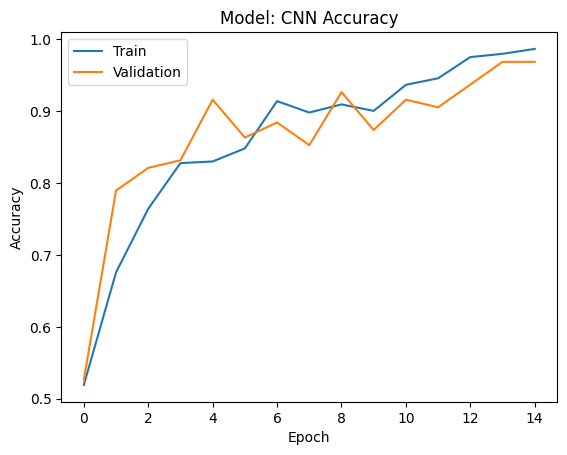

In [75]:
plot_training_accuracy(history_CNN, model_name="Model: CNN")

In [76]:
metrics_CNN = model_performance_classification_keras(model_CNN, X_val_gray, y_val_gray)
metrics_CNN

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step


Accuracy    Recall  Precision  F1 Score
0  0.968421  0.968421   0.968636  0.968421

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


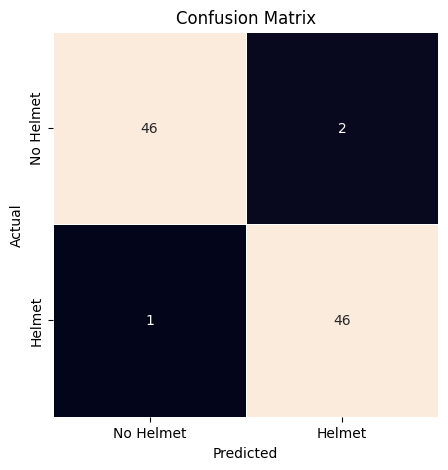

In [77]:
plot_confusion_matrix(model_CNN, X_val_gray, y_val_gray)

#### Vizualizing the predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


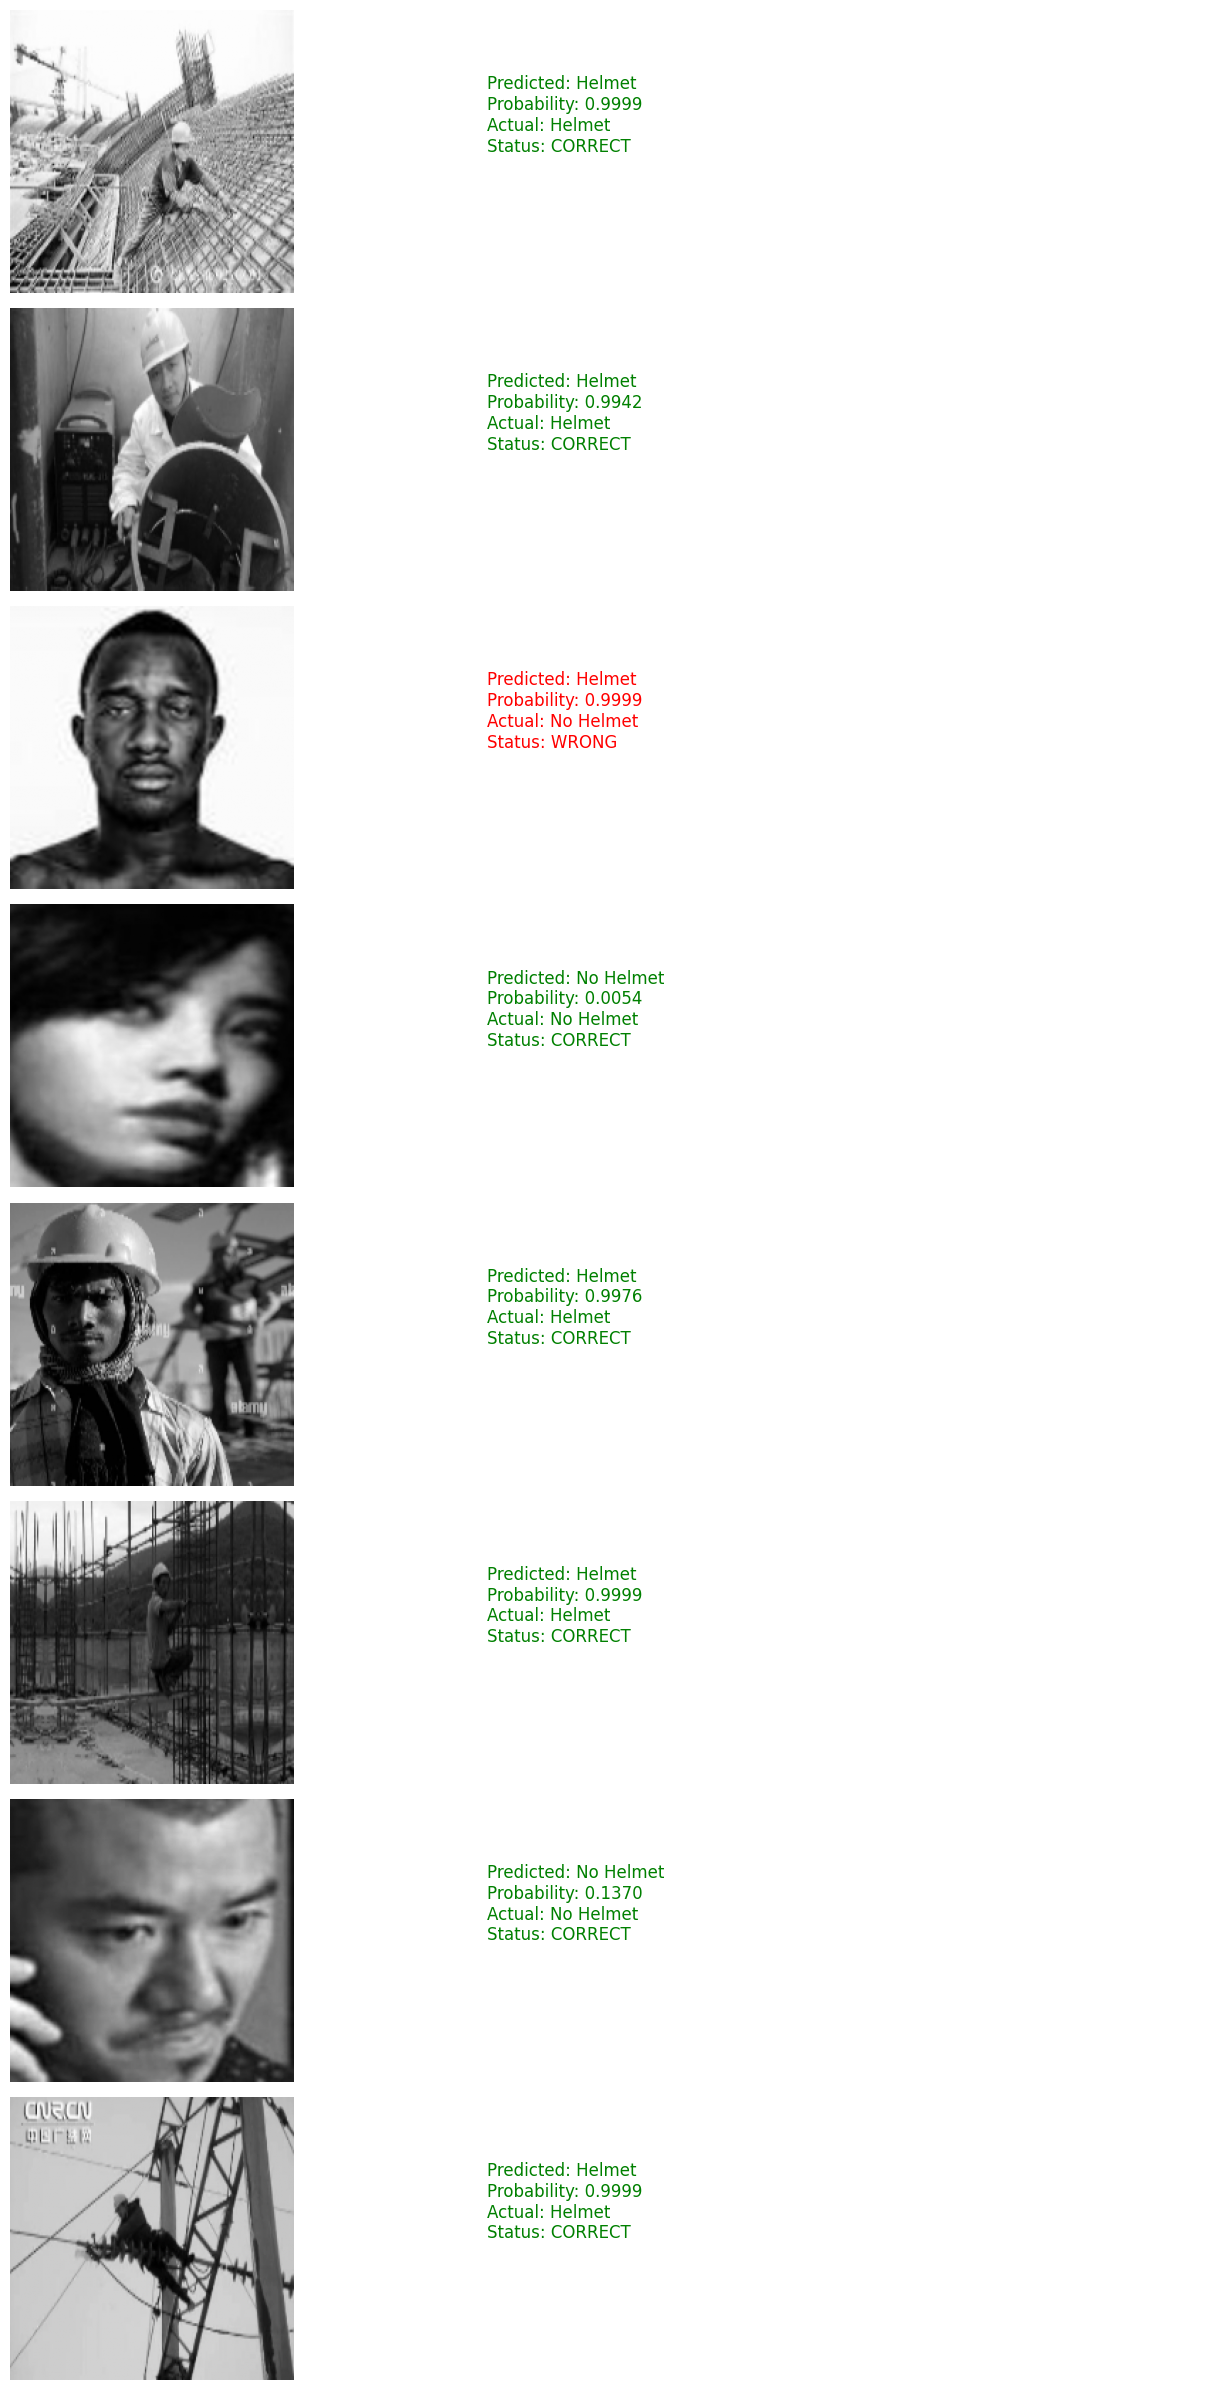

In [78]:
visualize_predictions(model_CNN, X_val_gray, y_val_gray)

#### Show misclassified images

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Total misclassified: 3


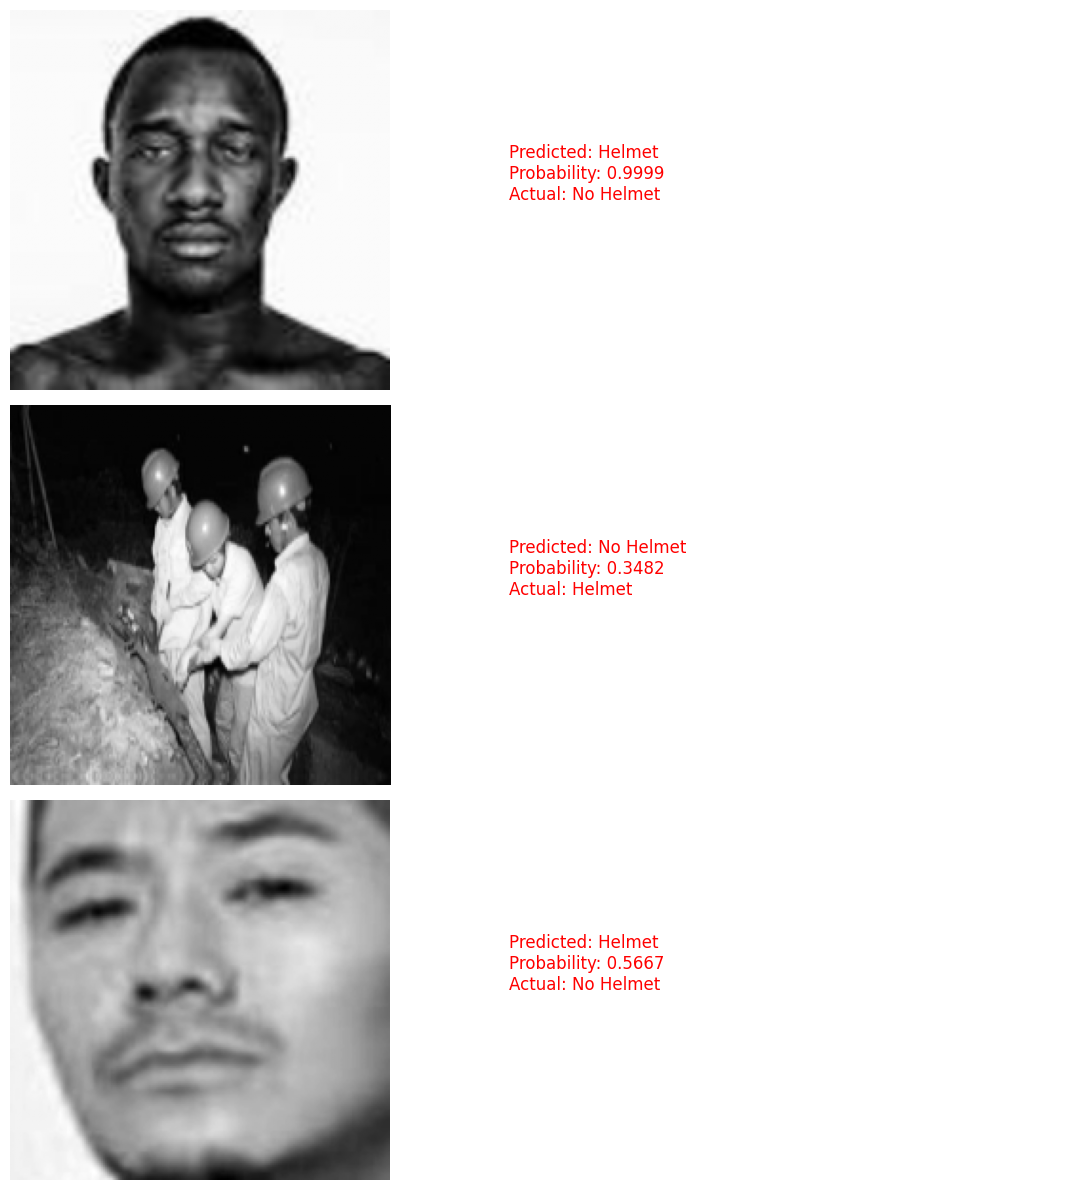

In [79]:
show_misclassified_images(model_CNN, X_val_gray, y_val_gray)

### Model 2: (VGG-16 (Base))

- The VGG-16 Base model achieved excellent validation performance (accuracy ~98.9%, strong precision/recall/F1), converging almost immediately due to the frozen pretrained backbone and simple classifier head. However, like the CNN, these results mainly reflect the structure of the dataset rather than true helmet-detection capability.
- The confusion matrix shows only one error, but reviewing the misclassified image reveals the same underlying issue: the model labeled a dark-skinned portrait as “Helmet,” even though visually similar lighter-skinned portraits were correctly classified as “No Helmet.” This indicates that the model is picking up on subtle cues correlated with the dataset rather than learning what helmets look like.
- Overall, VGG-16 Base performs extremely well numerically, but it is still driven by dataset bias and superficial visual patterns. It serves as a strong transfer-learning baseline, while also highlighting the limitations of the training data.

#### Code

In [80]:
vgg_base = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))
vgg_base.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_base.layers:
    layer.trainable = False

model_vgg = Sequential()

# Adding the convolutional part of the VGG16 model from above
model_vgg.add(vgg_base)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model_vgg.add(Flatten())

# Adding a dense output layer
model_vgg.add(Dense(1, activation='sigmoid'))

# Default Learning Rate
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

# Compile model
model_vgg.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

model_vgg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │        25,089 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,739,777 (56.23 MB)

 Trainable params: 25,089 (98.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [82]:
# Training settings
epochs = 20
batch_size = 128

history_vgg = model_vgg.fit(
    X_train_vgg,
    y_train_vgg,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_vgg, y_val_vgg),
    verbose=1
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 95s 18s/step - accuracy: 0.5658 - loss: 0.7580 - val_accuracy: 0.9579 - val_loss: 0.2366
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 601ms/step - accuracy: 0.9585 - loss: 0.1822 - val_accuracy: 1.0000 - val_loss: 0.0464
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 600ms/step - accuracy: 1.0000 - loss: 0.0291 - val_accuracy: 0.9789 - val_loss: 0.0500
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 600ms/step - accuracy: 1.0000 - loss: 0.0231 - val_accuracy: 0.9789 - val_loss: 0.0488
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 600ms/step - accuracy: 1.0000 - loss: 0.0157 - val_accuracy: 0.9789 - val_loss: 0.0360
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 598ms/step - accuracy: 1.0000 - loss: 0.0076 - val_accuracy: 0.9895 - val_loss: 0.0257
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 598ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.9895 - val_loss: 0.0196
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 597ms/step - accuracy: 1.0000 - loss: 0.0025 - val_accuracy: 0.9895 - val_loss: 

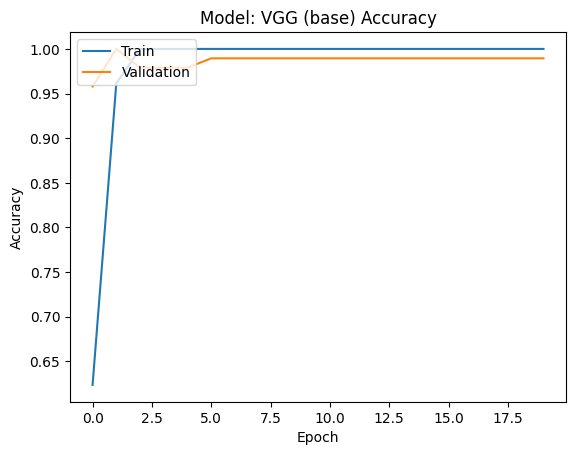

In [83]:
plot_training_accuracy(history_vgg, model_name="Model: VGG (base)")

In [84]:
metrics_vgg_base = model_performance_classification_keras(model_vgg, X_val_vgg, y_val_vgg)
metrics_vgg_base

3/3 ━━━━━━━━━━━━━━━━━━━━ 25s 6s/step


Accuracy    Recall  Precision  F1 Score
0  0.989474  0.989474   0.989693  0.989474

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step


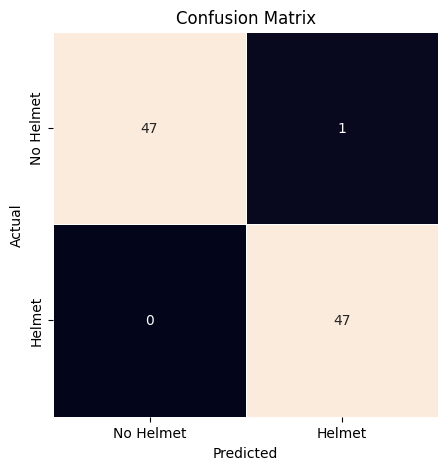

In [85]:
plot_confusion_matrix(model_vgg, X_val_vgg, y_val_vgg)

#### Visualizing the prediction:

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


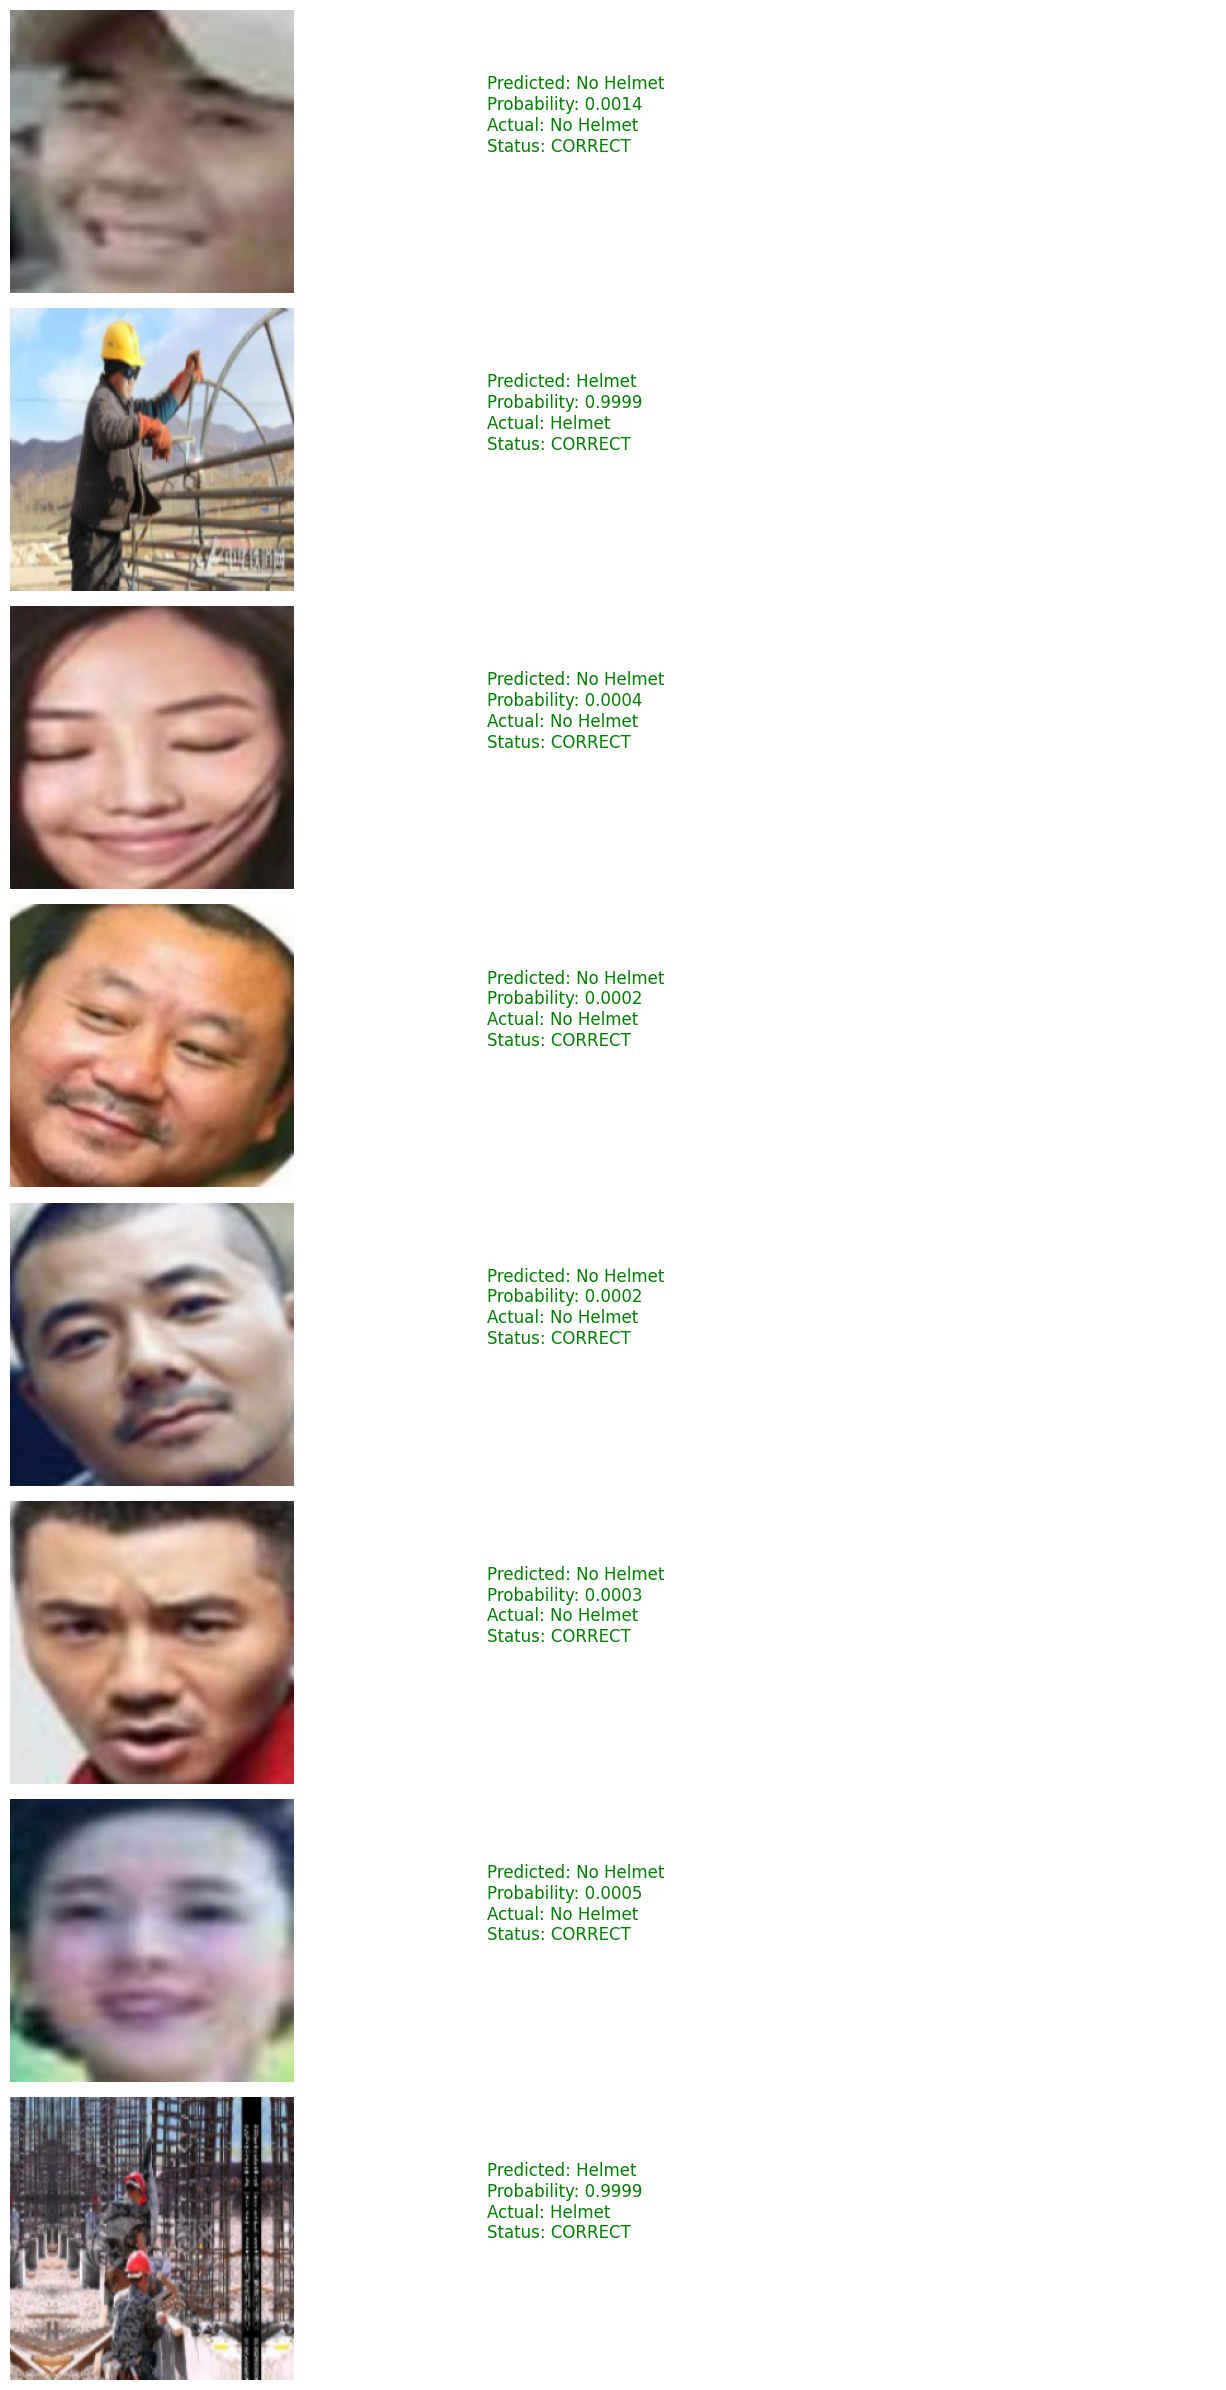

In [86]:
visualize_predictions(model_vgg, X_val_vgg, y_val_vgg)

#### Show misclassified images

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step
Total misclassified: 1


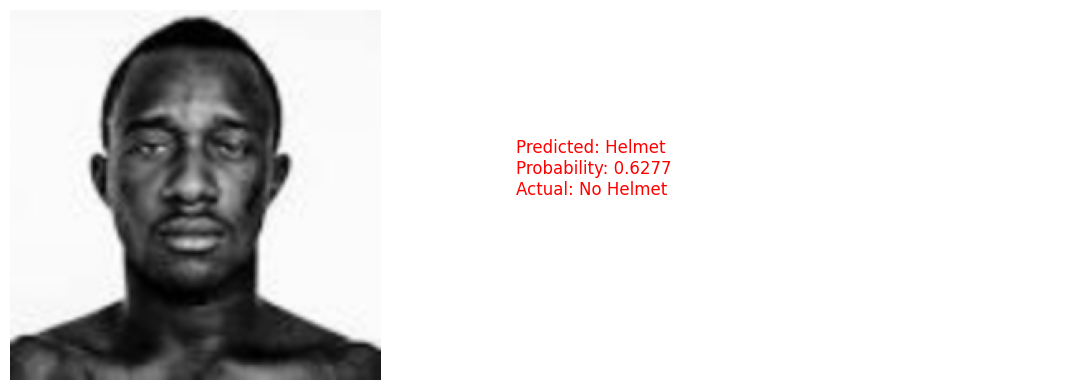

In [87]:
show_misclassified_images(model_vgg, X_val_vgg, y_val_vgg)

### Model 3: (VGG-16 (Base + FFNN))

#### Code

In [88]:
# Freeze the convolutional base
for layer in vgg_base.layers:
    layer.trainable = False

# Build the FFNN head on top of VGG base
model_vgg_ffnn = Sequential()
model_vgg_ffnn.add(vgg_base)
model_vgg_ffnn.add(Flatten())

# FFNN layers
model_vgg_ffnn.add(Dense(256, activation='relu'))
model_vgg_ffnn.add(Dropout(0.4))
model_vgg_ffnn.add(Dense(32, activation='relu'))

# Final output layer for binary classification
model_vgg_ffnn.add(Dense(1, activation='sigmoid'))

# Compile
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

model_vgg_ffnn.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Summary
model_vgg_ffnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,145,729 (80.66 MB)

 Trainable params: 6,431,041 (24.53 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [89]:
# Training settings
epochs = 20
batch_size = 128

history_vgg_ffnn = model_vgg_ffnn.fit(
    X_train_vgg,
    y_train_vgg,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_vgg, y_val_vgg),
    verbose=1
)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step - accuracy: 0.5507 - loss: 1.7407 - val_accuracy: 0.9789 - val_loss: 0.2015
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 598ms/step - accuracy: 0.9351 - loss: 0.1920 - val_accuracy: 0.9789 - val_loss: 0.0615
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 598ms/step - accuracy: 0.9962 - loss: 0.0302 - val_accuracy: 0.9895 - val_loss: 0.0291
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 598ms/step - accuracy: 0.9971 - loss: 0.0103 - val_accuracy: 0.9789 - val_loss: 0.0376
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 600ms/step - accuracy: 1.0000 - loss: 0.0046 - val_accuracy: 0.9789 - val_loss: 0.0530
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 601ms/step - accuracy: 1.0000 - loss: 0.0026 - val_accuracy: 0.9789 - val_loss: 0.0639
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 601ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9789 - val_loss: 0.0686
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 600ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.9789 - val_loss: 0.

In [90]:
metrics_vgg_base_ffnn = model_performance_classification_keras(model_vgg_ffnn, X_val_vgg, y_val_vgg)
metrics_vgg_base_ffnn

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 508ms/step


Accuracy    Recall  Precision  F1 Score
0  0.978947  0.978947   0.979807  0.978943

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


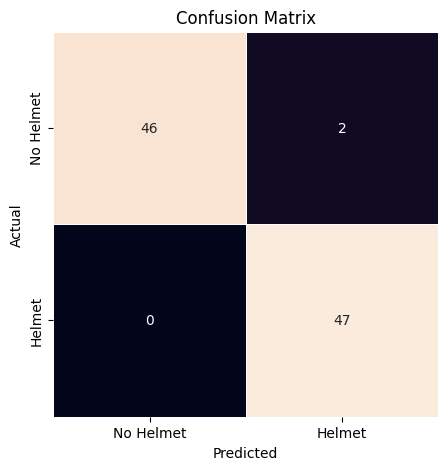

In [91]:
plot_confusion_matrix(model_vgg_ffnn, X_val_vgg, y_val_vgg)

#### Visualizing the predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 534ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


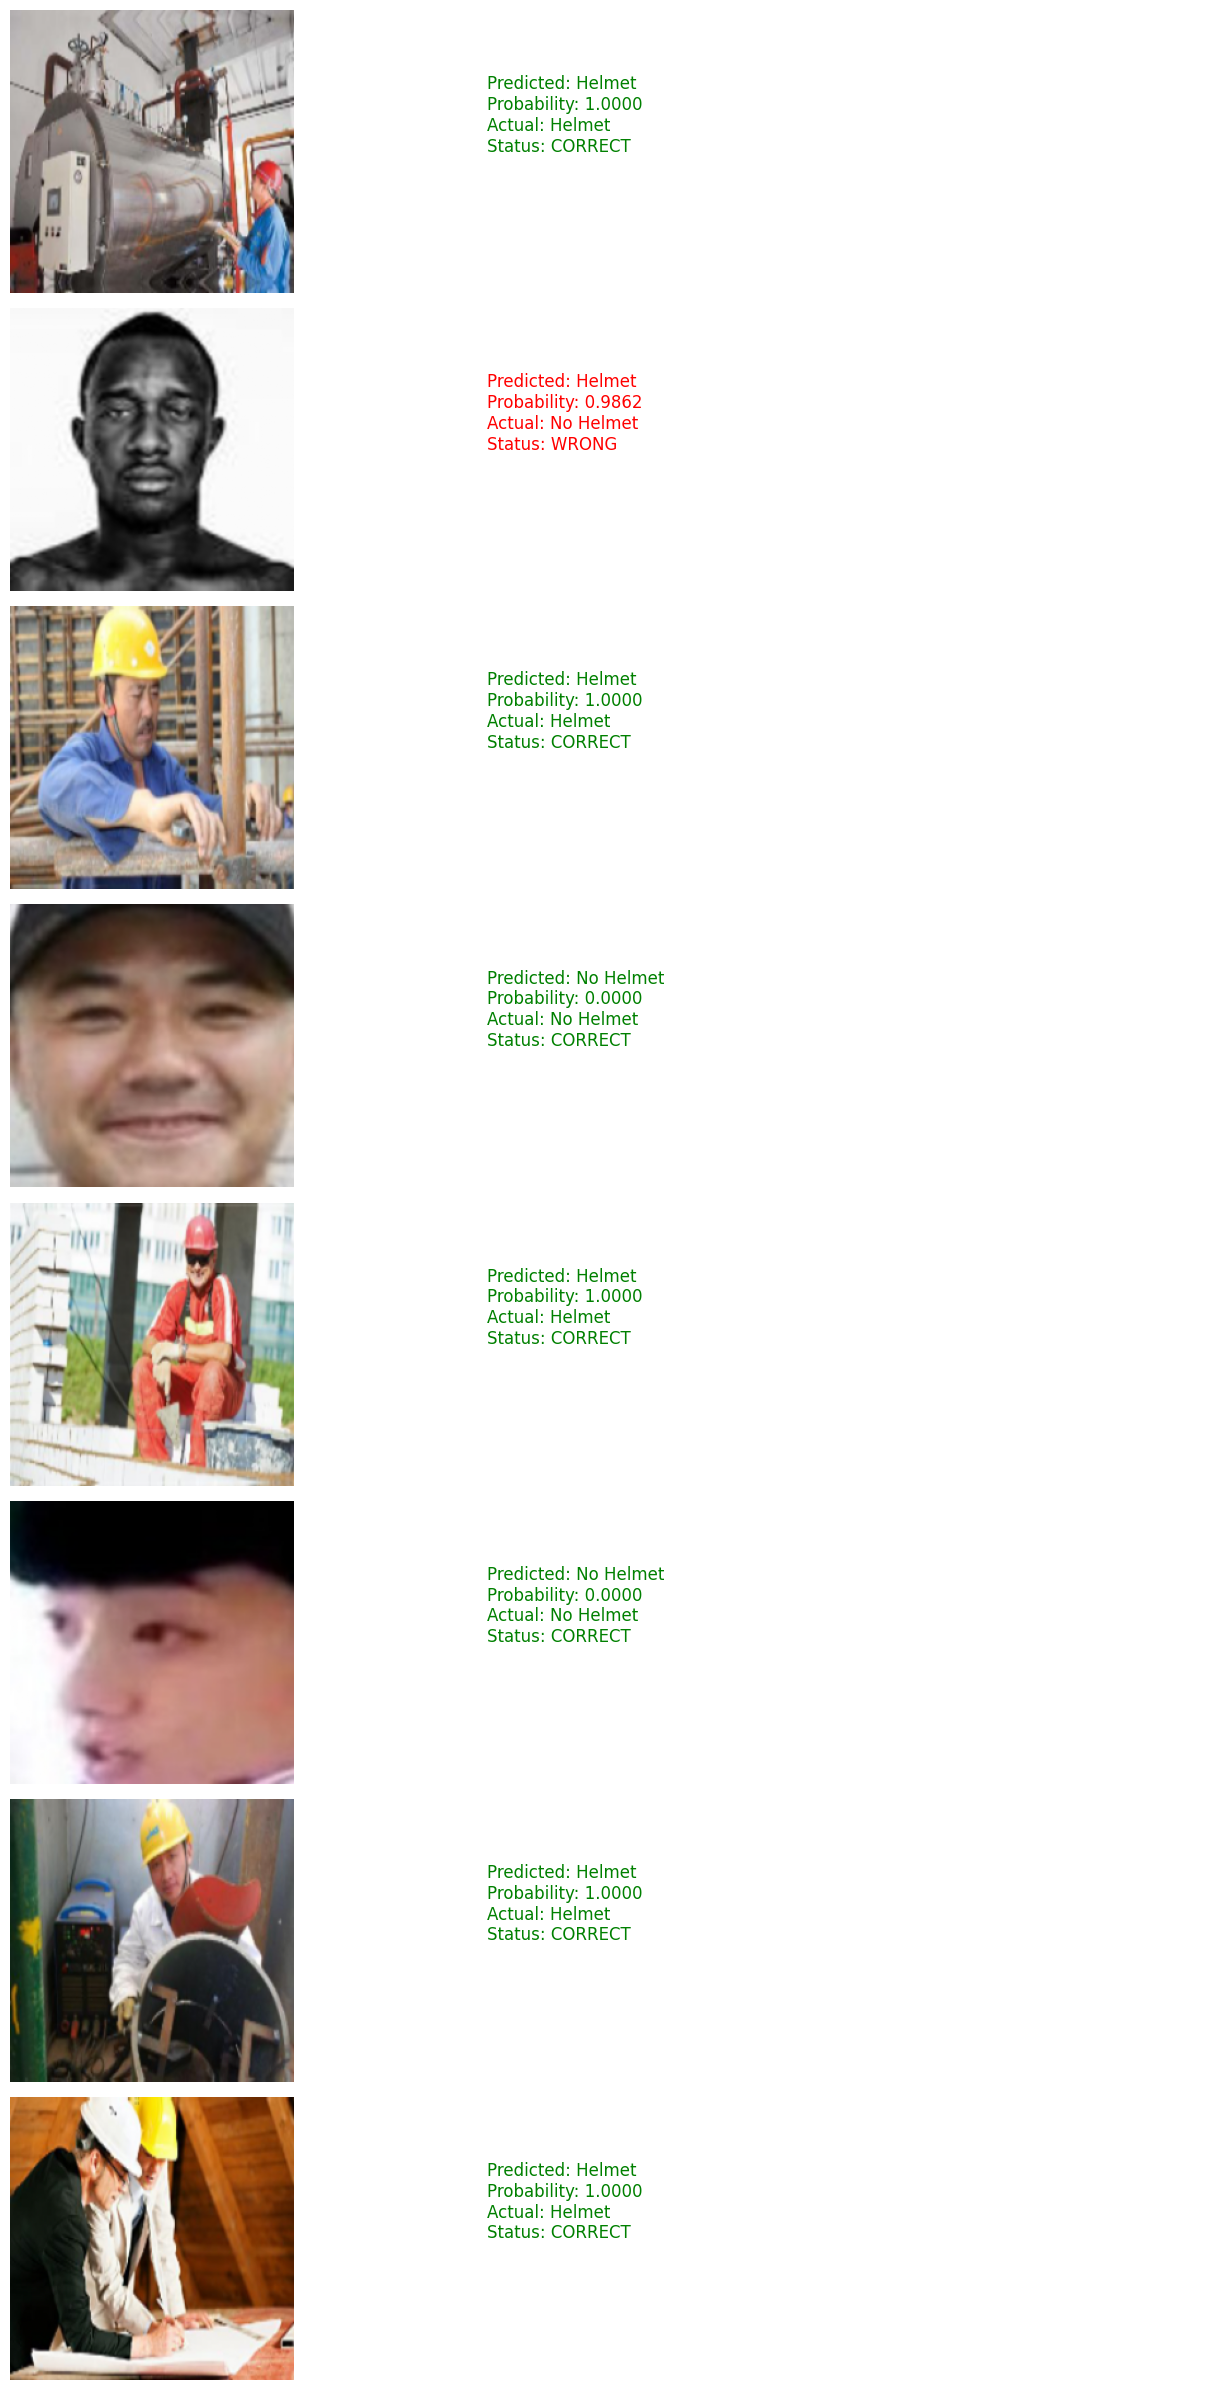

In [92]:
visualize_predictions(model_vgg_ffnn, X_val_vgg, y_val_vgg)

#### Show misclassified images

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
Total misclassified: 2


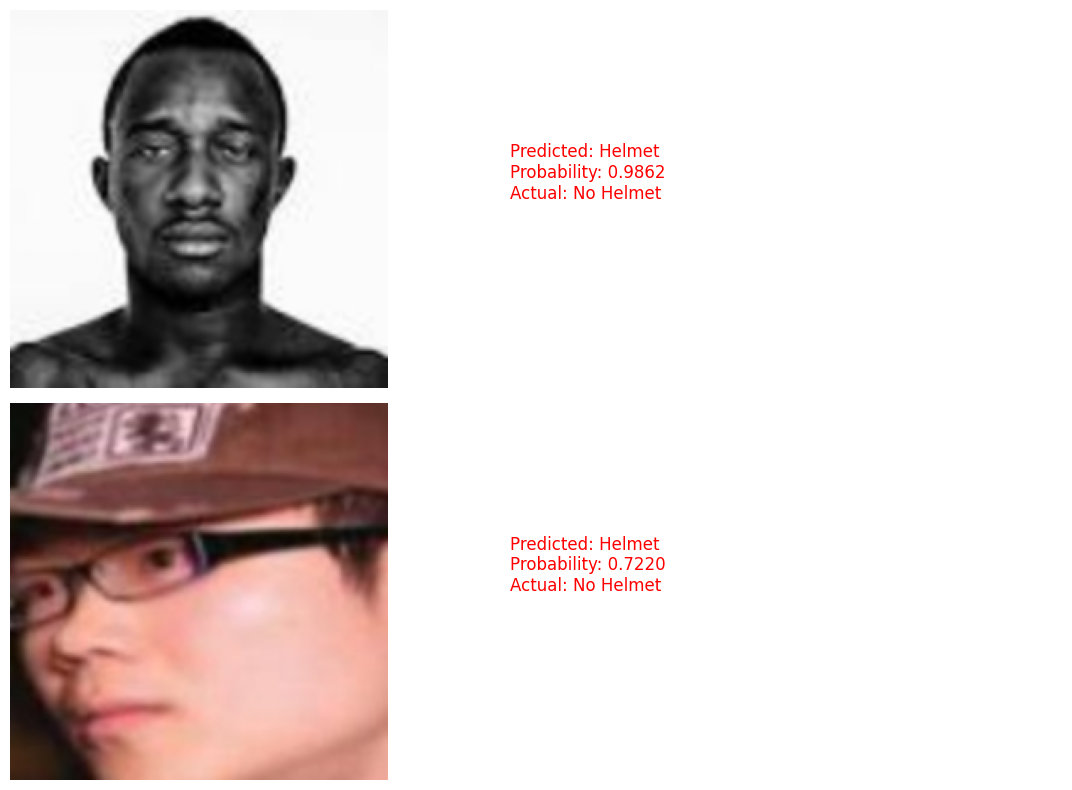

In [93]:
show_misclassified_images(model_vgg_ffnn, X_val_vgg, y_val_vgg)

### Model 4: (VGG-16 (Base + FFNN + Data Augmentation)

- This model introduces data augmentation and partial fine-tuning of the VGG-16 convolutional base. As expected, augmentation caused training to behave less smoothly than the earlier models, with more fluctuation in both loss and accuracy. Despite this, the model still achieved extremely strong validation performance, reaching ~98.9% accuracy with equally high precision, recall, and F1-score.
- The confusion matrix shows one misclassification: the same dark-skinned portrait that all prior models incorrectly labeled as “Helmet.” This confirms that augmentation did not correct the core issue—the model continues to rely on broad visual patterns in the dataset (portrait vs. construction scene) rather than helmet-specific features. In other words, augmentation added robustness but could not overcome the fundamental dataset bias.
- Overall, this model performs at nearly the same level as Models 2 and 3, demonstrating that even with augmentation and partial fine-tuning, the model remains limited by the quality and diversity of the original training images rather than by architecture.

#### Code

In [94]:
# Unfreezing the last two layers of the VGG base model (as in classroom example)
vgg_base.layers[-2].trainable = True
vgg_base.layers[-3].trainable = True

# Creating the Sequential model
model_vgg_aug = Sequential()

# Adding the convolutional part of the VGG16 model
model_vgg_aug.add(vgg_base)

# Flattening the VGG output
model_vgg_aug.add(Flatten())

# Adding the Feed Forward Neural Network (FFNN) head
model_vgg_aug.add(Dense(256, activation='relu'))
model_vgg_aug.add(Dropout(rate=0.4))
model_vgg_aug.add(Dense(32, activation='relu'))

# Binary output layer
model_vgg_aug.add(Dense(1, activation='sigmoid'))

# Compile the model
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model_vgg_aug.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

# Summary
model_vgg_aug.summary()

# DATA AUGMENTATION (training only)
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.20,
    height_shift_range=0.20,
    shear_range=0.30,
    zoom_range=0.40,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Creating the augmented training generator
train_generator = train_datagen.flow(
    X_train_vgg,
    y_train_vgg,
    batch_size=128,
    shuffle=True
)

# Validation generator (no augmentation)
val_datagen = ImageDataGenerator()
val_generator = val_datagen.flow(
    X_val_vgg,
    y_val_vgg,
    batch_size=128,
    shuffle=False
)

# TRAINING MODEL
history_vgg_aug = model_vgg_aug.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    verbose=1
)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,145,729 (80.66 MB)

 Trainable params: 11,150,657 (42.54 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.5119 - loss: 1.3224 - val_accuracy: 0.7263 - val_loss: 0.5895
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7012 - loss: 0.5852 - val_accuracy: 1.0000 - val_loss: 0.0140
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9723 - loss: 0.1350 - val_accuracy: 0.9053 - val_loss: 0.6337
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8849 - loss: 0.6499 - val_accuracy: 1.0000 - val_loss: 4.3334e-04
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.9947 - loss: 0.0262 - val_accuracy: 0.9789 - val_loss: 0.0810
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.9901 - loss: 0.0266 - val_accuracy: 1.0000 - val_loss: 0.0035
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9974 - loss: 0.0247 - val_accuracy: 0.9895 - val_loss: 0.0469
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.9973 - loss: 0.0181 - val_accuracy: 0.9895 - val_loss: 0.1079
Epoch 9/20


In [95]:
metrics_vgg_aug = model_performance_classification_keras(model_vgg_aug, X_val_vgg, y_val_vgg)
metrics_vgg_aug

3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 461ms/step


Accuracy    Recall  Precision  F1 Score
0  0.989474  0.989474   0.989693  0.989474

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 165ms/step


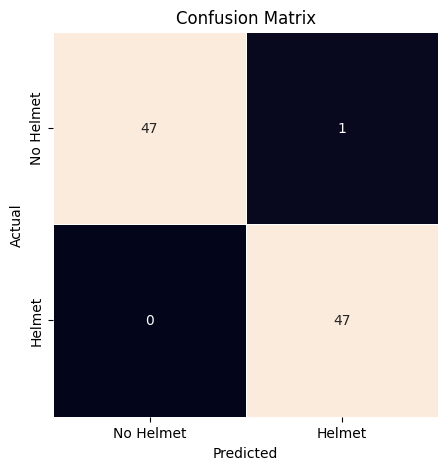

In [96]:
plot_confusion_matrix(model_vgg_aug, X_val_vgg, y_val_vgg)

#### Visualizing the predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


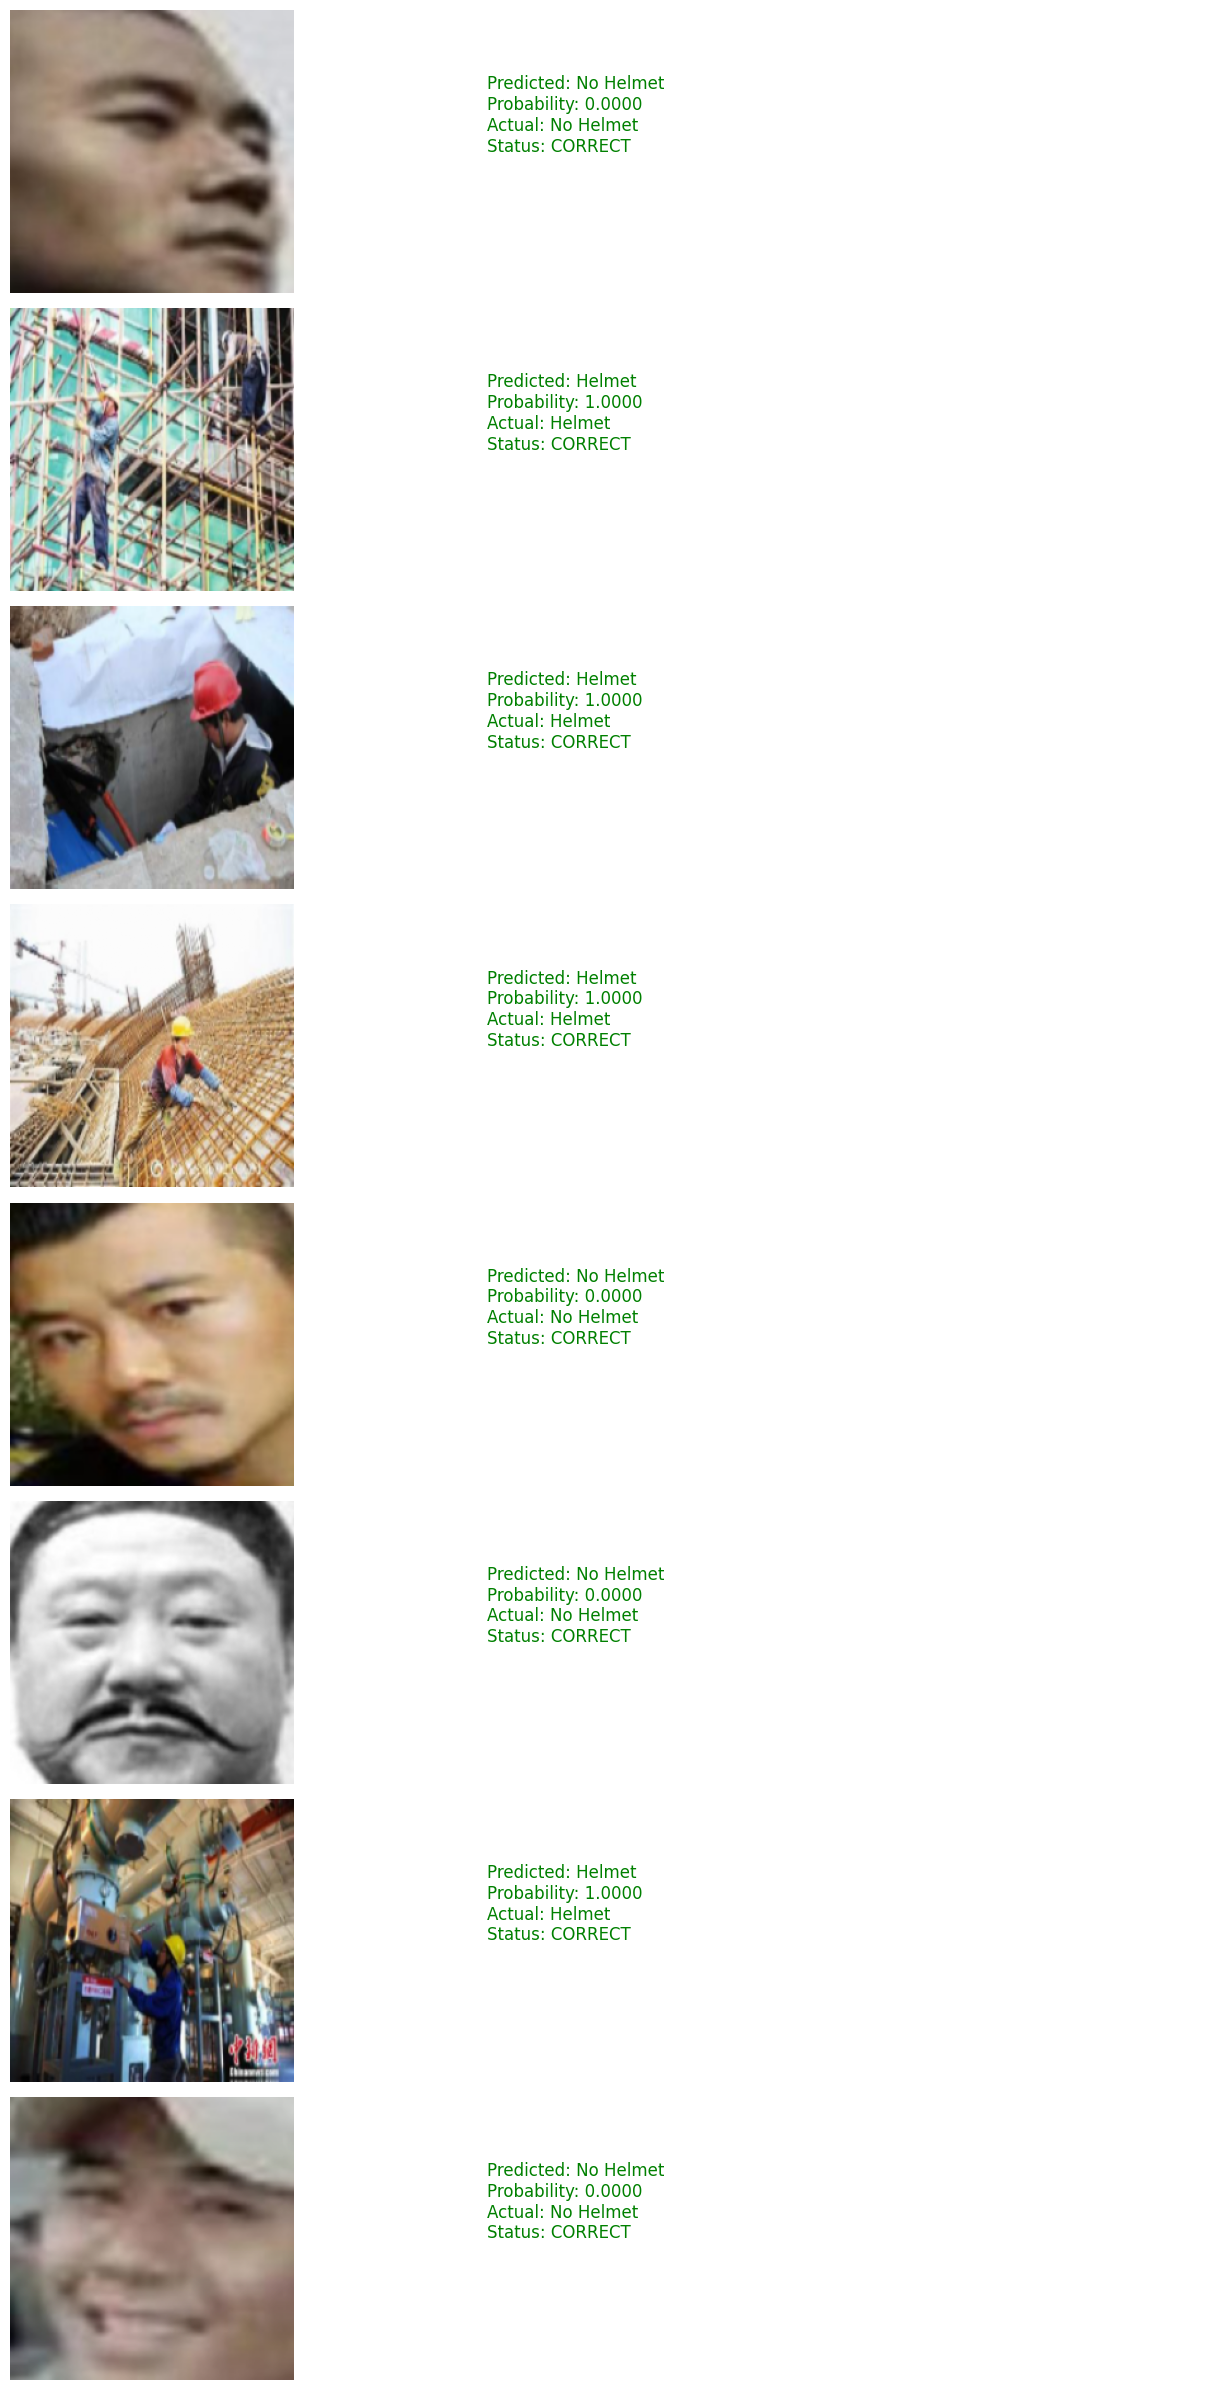

In [97]:
visualize_predictions(model_vgg_aug, X_val_vgg, y_val_vgg)

#### Show misclassified images

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 166ms/step
Total misclassified: 1


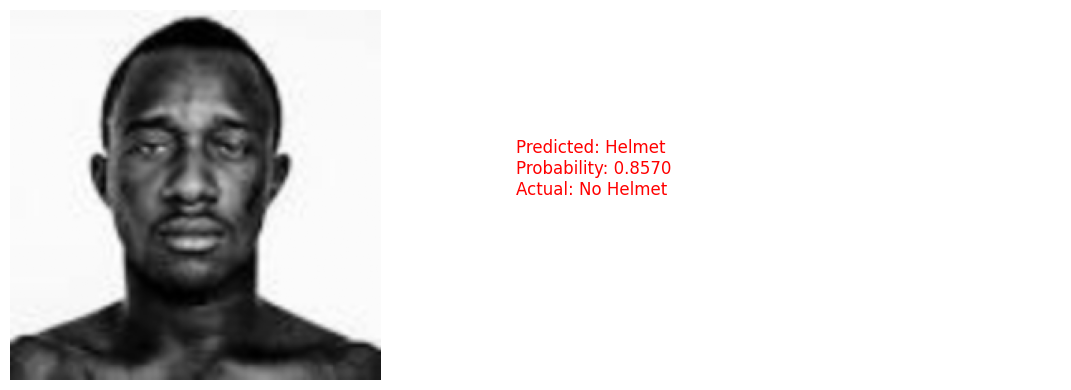

In [98]:
show_misclassified_images(model_vgg_aug, X_val_vgg, y_val_vgg)

# **Model Performance Comparison and Final Model Selection**

- All four models were evaluated on the held-out test set, which had not been used during training or validation. The baseline CNN achieved 94.7% accuracy, with precision, recall, and F1-score all around 0.95, confirming that it generalizes reasonably well but still makes a few mistakes on unseen data.
- In contrast, all three VGG-based models—VGG-16 Base, VGG-16 + FFNN, and VGG-16 + FFNN + Data Augmentation—achieved perfect test metrics, with 100% accuracy, precision, recall, and F1-score on this split. From a purely numerical standpoint, any of the VGG variants outperforms the baseline CNN on the test set.
- However, as previously noted these perfect scores should be interpreted with caution because the test set shares the same structural biases as the training and validation sets. As such, the VGG models are likely exploiting the same “portrait vs. construction scene” patterns rather than truly detecting helmets. The test results therefore show which models best fit this dataset, not which would be safest in a real deployment.

## Test Performance

In [99]:
# CNN test performance
metrics_cnn_test = model_performance_classification_keras(
    model_CNN,
    X_test_gray,
    y_test_gray
)
metrics_cnn_test

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


Accuracy    Recall  Precision  F1 Score
0  0.978947  0.978947   0.978947  0.978947

In [100]:
# VGG-16 Base (Model 2) test performance
metrics_vgg_test = model_performance_classification_keras(
    model_vgg,
    X_test_vgg,
    y_test_vgg
)
metrics_vgg_test


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0

In [101]:
# VGG-16 + FFNN (Model 3) test performance
metrics_ffnn_test = model_performance_classification_keras(
    model_vgg_ffnn,
    X_test_vgg,
    y_test_vgg
)
metrics_ffnn_test


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0

In [102]:
# VGG-16 + FFNN + Data Augmentation (Model 4) test performance
metrics_aug_test = model_performance_classification_keras(
    model_vgg_aug,
    X_test_vgg,
    y_test_vgg
)
metrics_aug_test


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


Accuracy  Recall  Precision  F1 Score
0       1.0     1.0        1.0       1.0

# **Actionable Insights & Recommendations**

The four models developed in this project all achieved extremely strong validation and test performance, with the VGG-based architectures reaching perfect scores. However, closer inspection of misclassified samples and class-level patterns indicates that these results do not reflect true helmet-detection capability. Instead, the models are primarily learning high-level scene differences: “portrait-style face images” versus “construction-site images.” As a result, model performance is artificially inflated by dataset bias rather than grounded in reliable, safety-critical feature recognition.

To build a model capable of detecting helmets in real operational settings, the following steps are recommended:

**Improve the quality and representativeness of the “No Helmet” class**

The most significant limitation of the current dataset is that nearly all “No Helmet” images are close-up portraits unrelated to industrial contexts. This class must be replaced or supplemented with realistic images of workers on job sites without helmets. Without such data, any model—regardless of architecture—will fail to learn meaningful distinctions between helmet and non-helmet conditions.

**Expand dataset diversity with a robust safety model requires variation in:**
- Skin tones
- Lighting and weather conditions
- Camera angles and distances
- Construction tasks and equipment
- Indoor vs. outdoor environments

These variations help the model generalize beyond narrow training patterns.

**Ensure balanced and clean data collection**

Both classes should include:
- Comparable image resolutions
- Similar framing and subject distance
- Mixed contexts (wide shots, mid shots, close-ups)

This reduces the risk that the model learns irrelevant cues (backgrounds, composition, etc.).

**Use data augmentation strategically**

Augmentation improved robustness but cannot compensate for weak underlying data. Once a high-quality dataset is available, augmentation should be applied thoughtfully to simulate real operational variability (minor rotations, moderate shifts, lighting variation).

**Re-train and evaluate with objective, safety-focused metrics**

After improving the dataset:
- Re-train all models
- Evaluate performance on a clean, well-curated test set
- **Prioritize false negatives** (predicting helmet when none is present) as the key risk metric
- Use confusion matrices, ROC curves, and threshold tuning to align the model with safety requirements

**Consider iterative data collection and model refinement**

A phased approach—collecting more realistic images, retraining, then analyzing misclassifications—will yield steady improvements and ensure the model progressively learns the correct visual features.

<font size=5 color='blue'>Power Ahead!</font>
___